In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow_decision_forests as tfdf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

2024-06-04 15:08:54.058630: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-04 15:08:54.058754: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-04 15:08:54.217679: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
train_df = pd.read_csv('/kaggle/input/stuntingtraining/train_dataset.csv')
test_df = pd.read_csv('/kaggle/input/stuntingtraining/test_dataset.csv')

train_df.head()

,Umur (bulan),Jenis Kelamin,Tinggi Badan (cm),Status Gizi
0,11,laki-laki,64.0,severely stunted
1,13,laki-laki,79.6,normal
2,15,perempuan,67.8,severely stunted
3,32,perempuan,85.3,normal
4,34,perempuan,79.0,severely stunted


In [3]:
print("Checking for NaN values in train_df:")
print(train_df.isna().sum())
print("Checking for NaN values in test_df:")
print(test_df.isna().sum())

print("Data types in train_df:")
print(train_df.dtypes)
print("Data types in test_df:")
print(test_df.dtypes)

Checking for NaN values in train_df:
Umur (bulan)         0
Jenis Kelamin        0
Tinggi Badan (cm)    0
Status Gizi          0
dtype: int64
Checking for NaN values in test_df:
Umur (bulan)         0
Jenis Kelamin        0
Tinggi Badan (cm)    0
Status Gizi          0
dtype: int64
Data types in train_df:
Umur (bulan)           int64
Jenis Kelamin         object
Tinggi Badan (cm)    float64
Status Gizi           object
dtype: object
Data types in test_df:
Umur (bulan)           int64
Jenis Kelamin         object
Tinggi Badan (cm)    float64
Status Gizi           object
dtype: object


In [4]:
train_df.rename(columns={
    "Umur (bulan)": "Umur_bulan",
    "Jenis Kelamin": "Jenis_Kelamin",
    "Tinggi Badan (cm)": "Tinggi_Badan_cm",
    "Status Gizi": "Gizi"
}, inplace=True)

test_df.rename(columns={
    "Umur (bulan)": "Umur_bulan",
    "Jenis Kelamin": "Jenis_Kelamin",
    "Tinggi Badan (cm)": "Tinggi_Badan_cm",
    "Status Gizi": "Gizi"
}, inplace=True)

print(train_df.columns)
print(test_df.columns)


Index(['Umur_bulan', 'Jenis_Kelamin', 'Tinggi_Badan_cm', 'Gizi'], dtype='object')
Index(['Umur_bulan', 'Jenis_Kelamin', 'Tinggi_Badan_cm', 'Gizi'], dtype='object')


In [5]:
train_df.columns = train_df.columns.str.strip() 
test_df.columns = test_df.columns.str.strip()

# Convert the dataset into a TensorFlow dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label='Gizi')
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df, label='Gizi')


## Decision Forest

In [6]:
model1 = tfdf.keras.RandomForestModel()
model1.fit(train_ds)

# Summary of the model structure.
model1.summary()

# Compute model accuracy.
model1.compile(metrics=["accuracy"])
model1.evaluate(test_ds, return_dict=True)

# Export the model to a SavedModel.
model1.save("project/model1")

Use /tmp/tmp52wlsrba as temporary training directory
Reading training dataset...
Training dataset read in 0:00:05.622037. Found 96799 examples.
Training model...


[INFO 24-06-04 15:09:25.5243 UTC kernel.cc:1233] Loading model from path /tmp/tmp52wlsrba/model/ with prefix 1a8475c797d84728


Model trained in 0:00:15.555115
Compiling model...


[INFO 24-06-04 15:09:27.3847 UTC decision_forest.cc:660] Model loaded with 300 root(s), 482202 node(s), and 3 input feature(s).
[INFO 24-06-04 15:09:27.3848 UTC abstract_model.cc:1344] Engine "RandomForestGeneric" built
[INFO 24-06-04 15:09:27.3848 UTC kernel.cc:1061] Use fast generic engine


Model compiled.
Model: "random_forest_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (3):
	Jenis_Kelamin
	Tinggi_Badan_cm
	Umur_bulan

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1. "Tinggi_Badan_cm"  1.000000 ################
    2.      "Umur_bulan"  0.500000 #######
    3.   "Jenis_Kelamin"  0.097402 

Variable Importance: NUM_AS_ROOT:
    1. "Tinggi_Badan_cm" 300.000000 

Variable Importance: NUM_NODES:
    1. "Tinggi_Badan_cm" 115353.000000 ################
    2.      "Umur_bulan" 86215.000000 #########
    3.   "Jenis_Kelamin" 39383.000000 

Variable Importance: SUM_SCORE:
    1. "Tinggi_Badan_cm" 18392450.196177 ################
    2.      

25/25 [==============================] - 2s 60ms/step


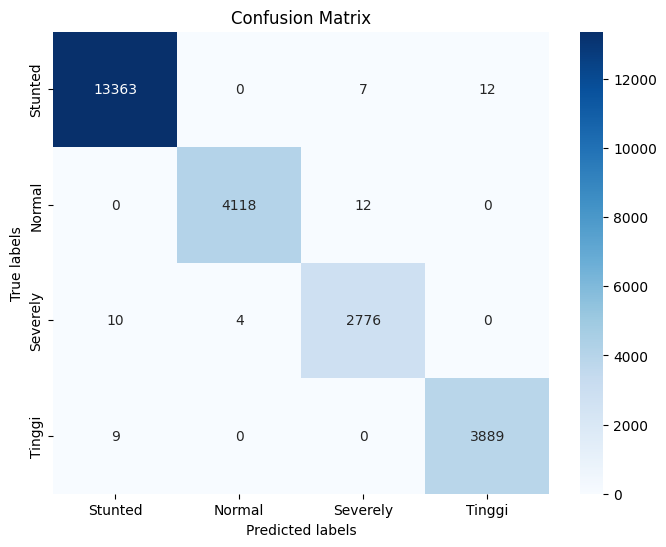

In [7]:
predictions = model1.predict(test_ds)
y_true = np.array([label for _, label in test_ds.unbatch()])

cm = confusion_matrix(y_true, np.argmax(predictions, axis=1))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Stunted', 'Normal', 'Severely', 'Tinggi'], yticklabels=['Stunted', 'Normal', 'Severely', 'Tinggi'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## Gradient Boost Trees 

In [8]:
input_features = ["Umur_bulan", "Jenis_Kelamin", "Tinggi_Badan_cm"]

model2 = tfdf.keras.GradientBoostedTreesModel(
    task=tfdf.keras.Task.CLASSIFICATION,
    features=[tfdf.keras.FeatureUsage(name=n) for n in input_features],
    exclude_non_specified_features=True,  # Only use the features in "features"
)
model2.fit(train_ds)

self_evaluation = model2.make_inspector().evaluation()
print(f"Accuracy: {self_evaluation.accuracy} Loss:{self_evaluation.loss}")

# Export the model to a SavedModel.
model1.save("project/model2")

Use /tmp/tmpnfge3wz6 as temporary training directory
Reading training dataset...


[WARNING 24-06-04 15:09:50.0394 UTC gradient_boosted_trees.cc:1886] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-04 15:09:50.0396 UTC gradient_boosted_trees.cc:1897] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-06-04 15:09:50.0396 UTC gradient_boosted_trees.cc:1911] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.390715. Found 96799 examples.
Training model...


[INFO 24-06-04 15:10:59.6383 UTC kernel.cc:1233] Loading model from path /tmp/tmpnfge3wz6/model/ with prefix 011e3e524c344181


Model trained in 0:01:09.465320
Compiling model...


[INFO 24-06-04 15:10:59.8899 UTC decision_forest.cc:660] Model loaded with 1200 root(s), 74874 node(s), and 3 input feature(s).
[INFO 24-06-04 15:10:59.8900 UTC abstract_model.cc:1344] Engine "GradientBoostedTreesGeneric" built
[INFO 24-06-04 15:10:59.8900 UTC kernel.cc:1061] Use fast generic engine


Model compiled.
Accuracy: 0.9987688660621643 Loss:0.02250324934720993


25/25 [==============================] - 2s 72ms/step


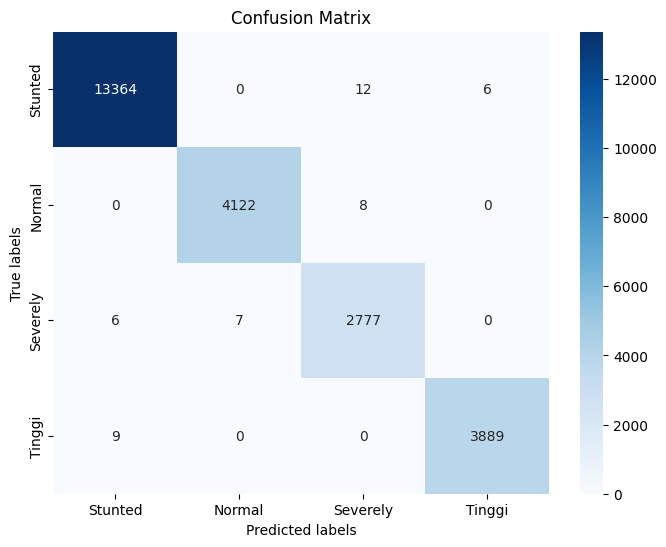

In [9]:
# Predict using the model
predictions = model2.predict(test_ds)

# Extract labels from the test dataset
y_true = np.array([label for _, label in test_ds.unbatch()])

# Generate confusion matrix
cm = confusion_matrix(y_true, np.argmax(predictions, axis=1))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Stunted', 'Normal', 'Severely', 'Tinggi'], yticklabels=['Stunted', 'Normal', 'Severely', 'Tinggi'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## Contoh Prediksi

In [10]:
input_data = {
    "Umur_bulan": [20],
    "Jenis_Kelamin": [1],
    "Tinggi_Badan_cm": [79],
}
input_df = pd.DataFrame(input_data)

input_ds = tfdf.keras.pd_dataframe_to_tf_dataset(input_df)

predictions = model1.predict(input_ds)
print(predictions)

kelas = ['Normal', 'Severely stunting', 'Stunting', 'Tinggi']
indeks_prediksi = np.argmax(predictions)
kelas_prediksi = kelas[indeks_prediksi]

print(f"Kategori Gizi: {kelas_prediksi}")

1/1 [==============================] - 0s 101ms/step
[[0.9933325  0.         0.00666667 0.        ]]
Kategori Gizi: Normal


In [11]:
# Example age in months
age = 10
# Example gender (1 for female)
gender = 1
# Starting height in cm
height = 50
# Set the initial category to 'Not Normal' to enter the loop
category = 'Not Normal'

while category != 'Normal':
    # Prepare input data
    input_data = {
        "Umur_bulan": [age],
        "Jenis_Kelamin": [gender],
        "Tinggi_Badan_cm": [height]
    }
    input_df = pd.DataFrame(input_data)
    
    # Convert the Pandas DataFrame to a TensorFlow dataset
    input_ds = tfdf.keras.pd_dataframe_to_tf_dataset(input_df)

    # Predict with the model
    predictions = model1.predict(input_ds)

    # Get the predicted category
    category_index = predictions[0].argmax(axis=None)  # Get the index of the predicted category
    category = 'Normal' if category_index == 0 else 'Not Normal'  # Assuming 'Normal' is the 0th index

    if category != 'Normal':
        height += 0.1  # Increase height by 0.1 cm for the next iteration

print(f"The minimum height required for a {age}-month-old female to be categorized as normal is {height} cm.")


1/1 [==============================] - 0s 55ms/step
The minimum height required for a 10-month-old female to be categorized as normal is 68.69999999999993 cm.


Normal - Severely Stunting - Stunting - Tinggi

In [12]:
import pandas as pd

results = []

for age in range(0, 60):  # Loop through ages from 1 to 60 months
    for gender in [0, 1]:
        height = 40  # Starting height in cm
        category = None

        while category != 'Normal':
            # Prepare input data
            input_data = {
            "Umur_bulan": [age],
            "Jenis_Kelamin": [gender],
            "Tinggi_Badan_cm": [height]
            }
            input_df = pd.DataFrame(input_data)
    
            # Convert the Pandas DataFrame to a TensorFlow dataset
            input_ds = tfdf.keras.pd_dataframe_to_tf_dataset(input_df)

            # Predict with the model
            predictions = model1.predict(input_ds)

            # Get the predicted category
            category_index = predictions[0].argmax(axis=None)  # Get the index of the predicted category
            category = 'Normal' if category_index == 0 else 'Not Normal'  # Assuming 'Normal' is the 0th index

            if category != 'Normal':
                height += 0.1  # Increase height by 0.1 cm for the next iteration

        results.append({"Umur_bulan": age, "Jenis_Kelamin": gender, "Tinggi_Minimal_cm": height})

results_df = pd.DataFrame(results)
print(results_df)

#Save the DataFrame to a CSV file
results_df.to_csv('/kaggle/working/minimum_height_thresholds.csv', index=False)

1/1 [==============================] - 0s 67ms/step
     Umur_bulan  Jenis_Kelamin  Tinggi_Minimal_cm
0             0              0               46.0
1             0              1               46.0
2             1              0               50.3
3             1              1               50.3
4             2              0               54.5
..          ...            ...                ...
115          57              1               99.1
116          58              0               99.3
117          58              1               99.3
118          59              0              100.3
119          59              1              100.3

[120 rows x 3 columns]


In [13]:
# Contoh data input untuk prediksi
input_data = {
    "Umur_bulan": [20],
    "Jenis_Kelamin": [1],
    "Tinggi_Badan_cm": [76],
}
input_df = pd.DataFrame(input_data)

# Konversi DataFrame menjadi TensorFlow Dataset
input_ds = tfdf.keras.pd_dataframe_to_tf_dataset(input_df)

# Gunakan model untuk membuat prediksi
predictions = model2.predict(input_ds)
print(predictions)

kelas = ['Normal', 'Severely stunting', 'Stunting', 'Tinggi']
indeks_prediksi = np.argmax(predictions)
kelas_prediksi = kelas[indeks_prediksi]

print(f"Kategori Gizi: {kelas_prediksi}")

1/1 [==============================] - 0s 118ms/step
[[2.0476326e-02 7.6416336e-02 9.0310609e-01 1.2972213e-06]]
Kategori Gizi: Stunting
